# Step 1: Preprocessing with Feature Mapping (using ResNet18)


In [1]:
import os
import pennylane as qml
from pennylane import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import shap
import torchvision.transforms as transforms
from torchvision import models

# Constants
SOI_PATH = '/home/HardDisk/yared/spectrogram-dataset/soi'
CWI_PATH = '/home/HardDisk/yared/spectrogram-dataset/cwi'
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32

# Preprocessing and ResNet feature extractor
device = 'cuda' if torch.cuda.is_available() else 'cpu'
resnet = models.resnet18(pretrained=True)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])  # Remove last layer
resnet = resnet.to(device)

# Updated transformation pipeline
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3 channels (RGB)
    transforms.ToTensor()
])

def load_images(folder_path, label):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path)
            img_tensor = transform(img).unsqueeze(0).to(device)
            features = resnet(img_tensor).cpu().detach().numpy().flatten()
            images.append(features)
            labels.append(label)
    return images, labels

# Load images and labels
soi_images, soi_labels = load_images(SOI_PATH, 0)
cwi_images, cwi_labels = load_images(CWI_PATH, 1)

# Combine and normalize features
X = np.array(soi_images + cwi_images)
X = (X - X.min()) / (X.max() - X.min())  # Normalize to [0, 1]

# Apply PCA for dimensionality reduction
pca = PCA(n_components=10)  # I can further adjust the number of components; maybe later
X_reduced = pca.fit_transform(X)

# Combine labels
y = np.array(soi_labels + cwi_labels)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42, stratify=y)

# Example output shapes
print(f'Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}')
print(f'Testing data shape: {X_test.shape}, Testing labels shape: {y_test.shape}')


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.


Training data shape: (6532, 10), Training labels shape: (6532,)
Testing data shape: (1634, 10), Testing labels shape: (1634,)


In [2]:
# Check the number of samples in each label for training and testing sets
train_labels, train_counts = np.unique(y_train, return_counts=True)
test_labels, test_counts = np.unique(y_test, return_counts=True)

# Print the number of samples for each label in the training set
print("Training set label distribution:")
for label, count in zip(train_labels, train_counts):
    print(f'Label {label}: {count} samples')

# Print the number of samples for each label in the testing set
print("Testing set label distribution:")
for label, count in zip(test_labels, test_counts):
    print(f'Label {label}: {count} samples')

Training set label distribution:
Label 0: 4767 samples
Label 1: 1765 samples
Testing set label distribution:
Label 0: 1193 samples
Label 1: 441 samples


# Step 2: Define the Quantum Circuit and QNN

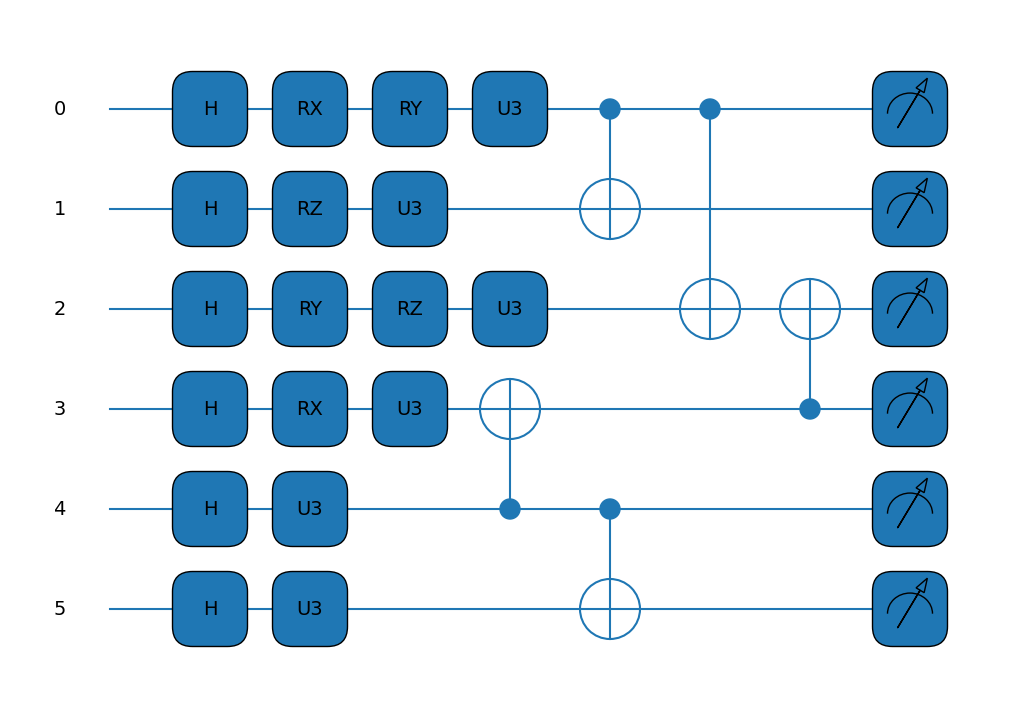

In [3]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import torch

# Quantum device setup
n_qubits = 6  # Adjust based on the number of qubits needed
dev = qml.device("default.qubit", wires=n_qubits)

# Define the quantum circuit
@qml.qnode(dev, interface='torch')
def quantum_circuit(inputs, weights):
    """Define a variational quantum circuit that matches the specified LaTeX structure."""

    # Step 1: Apply Hadamard gates to each qubit as per the initial superposition setup
    for i in range(n_qubits):
        qml.Hadamard(wires=i)

    # Step 2: Apply specific rotation gates on specified qubits
    qml.RX(inputs[0], wires=0)  # Rx on qubit 1
    qml.RY(inputs[1], wires=0)  # Ry on qubit 1
    qml.RZ(inputs[2], wires=1)  # Rz on qubit 2
    qml.RY(inputs[3], wires=2)  # Ry on qubit 3
    qml.RZ(inputs[4], wires=2)  # Rz on qubit 3
    qml.RX(inputs[5], wires=3)  # Rx on qubit 4

    # Step 3: Apply unitary gates (U(alpha), U(beta), ...) as U3 gates
    qml.U3(weights[0, 0, 0], weights[0, 0, 1], weights[0, 0, 2], wires=0)  # U(alpha) on qubit 1
    qml.U3(weights[0, 1, 0], weights[0, 1, 1], weights[0, 1, 2], wires=1)  # U(beta) on qubit 2
    qml.U3(weights[0, 2, 0], weights[0, 2, 1], weights[0, 2, 2], wires=2)  # U(delta) on qubit 3
    qml.U3(weights[0, 3, 0], weights[0, 3, 1], weights[0, 3, 2], wires=3)  # U(epsilon) on qubit 4
    qml.U3(weights[0, 4, 0], weights[0, 4, 1], weights[0, 4, 2], wires=4)  # U(zeta) on qubit 5
    qml.U3(weights[0, 5, 0], weights[0, 5, 1], weights[0, 5, 2], wires=5)  # U(eta) on qubit 6

    # Step 4: Apply entangling CNOT gates to match specified connections
    qml.CNOT(wires=[0, 1])  # Control qubit 1 to target qubit 2
    qml.CNOT(wires=[0, 2])  # Control qubit 1 to target qubit 3
    qml.CNOT(wires=[4, 3])  # Control qubit 4 to target qubit 5
    qml.CNOT(wires=[3, 2])  # Control qubit 4 to target qubit 3
    qml.CNOT(wires=[4, 5])  # Control qubit 4 to target qubit 3

    # Step 5: Measurements on all qubits
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Define the weight shape dictionary for TorchLayer
weights_shape = {"weights": (1, n_qubits, 3)}

# QNN model that uses the defined quantum circuit
qnn = qml.qnn.TorchLayer(quantum_circuit, weights_shape)

# Visualize the circuit
inputs = np.random.rand(n_qubits)  # Random input values for the gates
weights = np.random.rand(1, n_qubits, 3)  # Random weights for the U3 unitaries
fig, ax = qml.draw_mpl(quantum_circuit)(inputs, weights)
plt.show()


# Step 3: Combine ResNet-18 and QNN for Classification

In [4]:
import torch.nn as nn

class HybridModel(nn.Module):
    def __init__(self, input_size):
        super(HybridModel, self).__init__()
        self.fc = nn.Linear(input_size, n_qubits)  # ResNet18 output to qubit input size
        self.qnn = qnn
        self.output = nn.Linear(n_qubits, 1)  # Binary classification
    
    def forward(self, x):
        x = self.fc(x)
        x = self.qnn(x)
        x = torch.sigmoid(self.output(x))
        return x

# Step 4: Train and Evaluate the Model

In [5]:
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch

# Assuming `X_train`, `y_train`, `X_test`, `y_test`, `BATCH_SIZE`, and `HybridModel` from above

input_size = X_reduced.shape[1]  # Number of features after PCA
model = HybridModel(input_size=input_size).cuda()

# Prepare data loaders
train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

test_data = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Initialize lists to store loss and accuracy values
loss_values = []
accuracy_values = []
val_losses = []
val_accuracy_values = []

# # Ensure y_train is converted to a NumPy array to calculate class counts
# y_train_np = y_train.numpy() if isinstance(y_train, torch.Tensor) else np.array(y_train)

# Calculate class counts with return_counts=True
class_labels, class_counts = np.unique(y_train, return_counts=True)
total_samples = len(y_train)

# Calculate class weights for balanced weighting
class_weights = [total_samples / (2 * count) for count in class_counts]

# Convert class weights to a tensor
weights_tensor = torch.tensor(class_weights, dtype=torch.float32).cuda()


# Adjusted training function with class weights
def train_model(epochs):
    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        total_loss = 0
        correct = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
            optimizer.zero_grad()
            
            output = model(X_batch).squeeze(1)  # Squeeze to match shape
            # Apply class weights based on the labels
            weights = weights_tensor[y_batch.long()]  # Select weights for current batch
            
            loss = F.binary_cross_entropy(output, y_batch, weight=weights)  # Weighted loss
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            correct += ((output > 0.5) == y_batch).float().sum().item()  # Calculate correct predictions

        # Calculate average loss and accuracy for the epoch
        avg_loss = total_loss / len(train_loader)
        accuracy = correct / len(train_loader.dataset)
        
        loss_values.append(avg_loss)
        accuracy_values.append(accuracy)

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        val_loss = 0
        val_correct = 0
        with torch.no_grad():  # Disable gradient calculation for validation
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
                output = model(X_batch).squeeze(1)
                loss = F.binary_cross_entropy(output, y_batch)
                val_loss += loss.item()
                val_correct += ((output > 0.5) == y_batch).float().sum().item()

        avg_val_loss = val_loss / len(test_loader)
        val_accuracy = val_correct / len(test_loader.dataset)
        
        val_losses.append(avg_val_loss)
        val_accuracy_values.append(val_accuracy)

        print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

# Train the model with class weights applied
train_model(epochs=25)


Epoch 1, Loss: 0.6941, Accuracy: 0.2702, Val Loss: 0.6990, Val Accuracy: 0.2699
Epoch 2, Loss: 0.6922, Accuracy: 0.6829, Val Loss: 0.6896, Val Accuracy: 0.5863
Epoch 3, Loss: 0.6653, Accuracy: 0.6895, Val Loss: 0.6479, Val Accuracy: 0.6848
Epoch 4, Loss: 0.5917, Accuracy: 0.7280, Val Loss: 0.5712, Val Accuracy: 0.7081
Epoch 5, Loss: 0.5361, Accuracy: 0.7359, Val Loss: 0.5627, Val Accuracy: 0.6995
Epoch 6, Loss: 0.5089, Accuracy: 0.7347, Val Loss: 0.5463, Val Accuracy: 0.7062
Epoch 7, Loss: 0.4956, Accuracy: 0.7352, Val Loss: 0.5278, Val Accuracy: 0.7118
Epoch 8, Loss: 0.4855, Accuracy: 0.7368, Val Loss: 0.5256, Val Accuracy: 0.7111
Epoch 9, Loss: 0.4782, Accuracy: 0.7404, Val Loss: 0.5193, Val Accuracy: 0.7081
Epoch 10, Loss: 0.4701, Accuracy: 0.7488, Val Loss: 0.5114, Val Accuracy: 0.7173
Epoch 11, Loss: 0.4638, Accuracy: 0.7564, Val Loss: 0.5014, Val Accuracy: 0.7368
Epoch 12, Loss: 0.4596, Accuracy: 0.7719, Val Loss: 0.4985, Val Accuracy: 0.7454
Epoch 13, Loss: 0.4559, Accuracy: 0.7

# To see how original ResNet features contribute to PCA components

In [6]:
# To see how original ResNet features contribute to PCA components
def analyze_pca_components():
    print("\nTop ResNet Features Contributing to Each PCA Component:")
    for i in range(pca.n_components_):
        print(f"\nPCA Component {i+1} (Explains {pca.explained_variance_ratio_[i]:.1%} variance)")
        # Get top 5 contributing features
        top_indices = np.abs(pca.components_[i]).argsort()[-5:][::-1]
        for idx in top_indices:
            print(f"ResNet feature {idx}: {pca.components_[i][idx]:.3f}")

analyze_pca_components()


Top ResNet Features Contributing to Each PCA Component:

PCA Component 1 (Explains 2.3% variance)
ResNet feature 209: -0.169
ResNet feature 273: -0.153
ResNet feature 208: -0.140
ResNet feature 297: -0.136
ResNet feature 147: -0.134

PCA Component 2 (Explains 1.3% variance)
ResNet feature 453: -0.238
ResNet feature 474: 0.180
ResNet feature 192: 0.135
ResNet feature 296: 0.133
ResNet feature 186: 0.130

PCA Component 3 (Explains 1.3% variance)
ResNet feature 297: -0.214
ResNet feature 319: 0.172
ResNet feature 44: 0.151
ResNet feature 164: -0.140
ResNet feature 280: -0.128

PCA Component 4 (Explains 0.8% variance)
ResNet feature 319: 0.168
ResNet feature 21: 0.157
ResNet feature 143: -0.146
ResNet feature 426: 0.146
ResNet feature 7: 0.142

PCA Component 5 (Explains 0.8% variance)
ResNet feature 287: 0.184
ResNet feature 38: 0.158
ResNet feature 1: 0.155
ResNet feature 368: 0.151
ResNet feature 37: 0.139

PCA Component 6 (Explains 0.7% variance)
ResNet feature 147: -0.184
ResNet featu

# 1. First, keep your existing evaluation function

In [7]:

def evaluate():
    model.eval()
    y_pred = []
    y_true = []
    x_test_all = []  # Add this to store features
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch).squeeze(1)
            y_pred.extend((output > 0.5).cpu().numpy())
            y_true.extend(y_batch.cpu().numpy())
            x_test_all.extend(X_batch.cpu().numpy())  # Store features
    
    return np.array(y_true), np.array(y_pred), np.array(x_test_all)

# 2. Get the predictions and features

In [8]:

y_true, y_pred, X_test = evaluate()

# 3. Add this function for SHAP compatibility

In [9]:

def model_predict(X):
    model.eval()
    with torch.no_grad():
        X_tensor = torch.FloatTensor(X).to(device)
        output = model(X_tensor).squeeze(1)
        return output.cpu().numpy()


Detailed Classification Report:
              precision    recall  f1-score   support

         SOI       0.90      0.76      0.82      1193
     SOI+CWI       0.54      0.77      0.64       441

    accuracy                           0.76      1634
   macro avg       0.72      0.77      0.73      1634
weighted avg       0.80      0.76      0.77      1634


Additional Metrics:
Precision: 0.544
Recall: 0.769
F1 Score: 0.637
ROC AUC: 0.765

SHAP analysis failed with error: Unknown instance type: <class 'pennylane.numpy.tensor.tensor'>


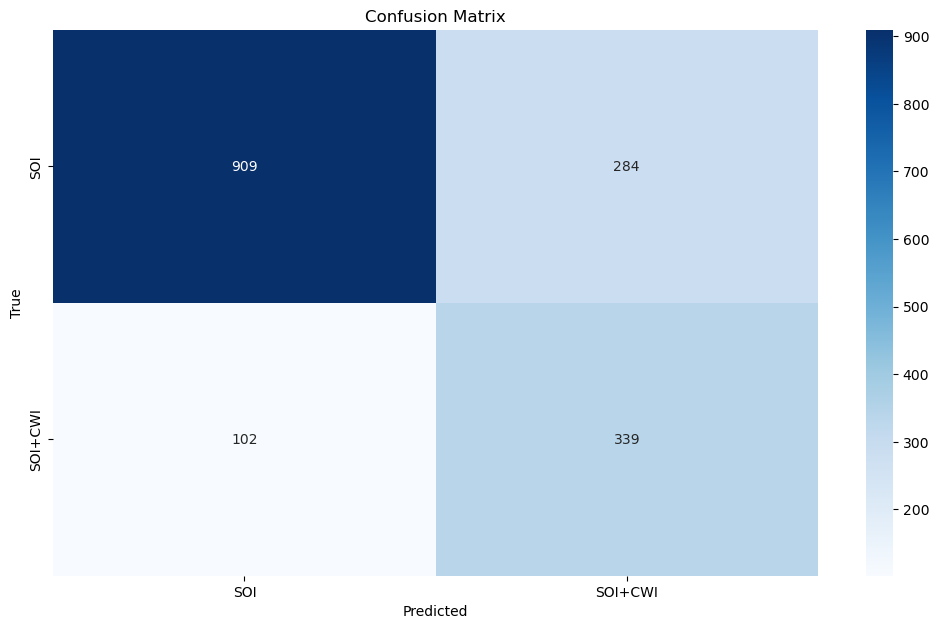

In [10]:
# 1. First, define feature names based on PCA components and their explained variance
feature_names = [f'PCA_{i+1} ({pca.explained_variance_ratio_[i]:.1%} var)' for i in range(10)]

# 2. After your model training, add this code for evaluation and SHAP analysis:
def analyze_model_performance():
    # Get predictions and features
    model.eval()
    y_pred = []
    y_true = []
    x_test_all = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
            output = model(X_batch).squeeze(1)
            y_pred.extend((output > 0.5).cpu().numpy())
            y_true.extend(y_batch.cpu().numpy())
            x_test_all.extend(X_batch.cpu().numpy())
    
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    X_test_array = np.array(x_test_all)

    # Create figure for visualization
    plt.figure(figsize=(20, 12))
    
    # 1. Confusion Matrix
    plt.subplot(2, 2, 1)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['SOI', 'SOI+CWI'],
                yticklabels=['SOI', 'SOI+CWI'])
    plt.title('Confusion Matrix', fontsize=12)
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # 2. Print detailed metrics
    print("\nDetailed Classification Report:")
    print(classification_report(y_true, y_pred, target_names=['SOI', 'SOI+CWI']))
    
    # Calculate additional metrics
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    try:
        auc = roc_auc_score(y_true, y_pred)
    except:
        auc = None

    print(f"\nAdditional Metrics:")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"F1 Score: {f1:.3f}")
    if auc:
        print(f"ROC AUC: {auc:.3f}")

    # 3. SHAP Analysis
    def model_predict(X):
        model.eval()
        with torch.no_grad():
            X_tensor = torch.FloatTensor(X).cuda()
            output = model(X_tensor).squeeze(1)
            return output.cpu().numpy()

    try:
        # Use a subset of test data as background
        background_data = X_test_array[:50]  # Reduced sample size for speed
        
        # Initialize SHAP explainer
        explainer = shap.KernelExplainer(model_predict, background_data)
        
        # Calculate SHAP values
        shap_values = explainer.shap_values(X_test_array[:50])
        
        # SHAP Summary Plot
        plt.subplot(2, 2, 2)
        shap.summary_plot(shap_values, X_test_array[:50],
                         feature_names=feature_names,
                         plot_type='bar',
                         show=False)
        plt.title('Feature Importance (SHAP)', fontsize=12)
        
        # SHAP Dependence Plot
        plt.subplot(2, 2, 3)
        mean_abs_shap = np.abs(shap_values).mean(0)
        most_important_feature = np.argmax(mean_abs_shap)
        
        shap.dependence_plot(most_important_feature,
                           shap_values,
                           X_test_array[:50],
                           feature_names=feature_names,
                           show=False)
        plt.title(f'Dependency Plot: {feature_names[most_important_feature]}', fontsize=12)
        
        # 4. PCA Explained Variance
        plt.subplot(2, 2, 4)
        explained_variance = pca.explained_variance_ratio_
        cum_explained_variance = np.cumsum(explained_variance)
        
        plt.plot(range(1, len(explained_variance) + 1), 
                cum_explained_variance, 
                'bo-', label='Cumulative')
        plt.plot(range(1, len(explained_variance) + 1), 
                explained_variance, 
                'ro-', label='Individual')
        plt.xlabel('Number of Components')
        plt.ylabel('Explained Variance Ratio')
        plt.title('PCA Explained Variance', fontsize=12)
        plt.legend()
        
        # Calculate and print feature importance
        feature_importance = pd.DataFrame({
            'Feature': feature_names,
            'SHAP Importance': np.abs(shap_values).mean(0),
            'PCA Variance': pca.explained_variance_ratio_
        })
        feature_importance = feature_importance.sort_values('SHAP Importance', ascending=False)
        
        print("\nFeature Importance Analysis:")
        print(feature_importance.round(4))
        
        # Save feature importance
        feature_importance.to_csv('feature_importance_analysis.csv', index=False)
        
    except Exception as e:
        print(f"\nSHAP analysis failed with error: {str(e)}")

    plt.tight_layout()
    plt.show()

# Call the analysis function after training
analyze_model_performance()

# 4. Now add the SHAP analysis


Classification Report:
              precision    recall  f1-score   support

         SOI       0.90      0.76      0.82      1193
     SOI+CWI       0.54      0.77      0.64       441

    accuracy                           0.76      1634
   macro avg       0.72      0.77      0.73      1634
weighted avg       0.80      0.76      0.77      1634

SHAP analysis failed with error: Unknown instance type: <class 'pennylane.numpy.tensor.tensor'>


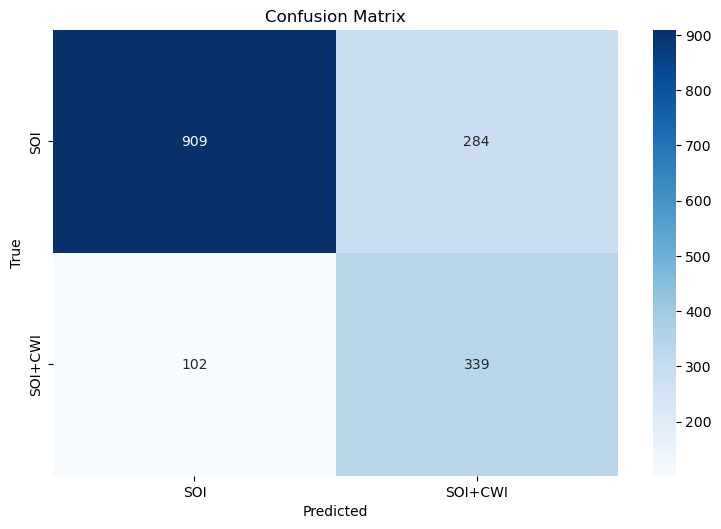

In [11]:

import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# First plot your existing confusion matrix
plt.figure(figsize=(15, 10))

# Confusion Matrix
plt.subplot(2, 2, 1)
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['SOI', 'SOI+CWI'], 
            yticklabels=['SOI', 'SOI+CWI'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['SOI', 'SOI+CWI']))

# SHAP Analysis
try:
    # Use a subset of test data as background
    background_data = X_test[:50]  # Use first 100 samples as background
    
    # Initialize SHAP explainer
    explainer = shap.KernelExplainer(model_predict, background_data)
    
    # Calculate SHAP values for a subset of test data
    shap_values = explainer.shap_values(X_test[:100])  # Use subset for efficiency
    
    # SHAP Summary Plot
    plt.subplot(2, 2, 2)
    shap.summary_plot(shap_values, X_test[:100],
                     feature_names=feature_names if 'feature_names' in locals() else None,
                     plot_type='bar',
                     show=False)
    plt.title('SHAP Feature Importance')
    
    # SHAP Dependency Plot
    plt.subplot(2, 2, 3)
    mean_abs_shap = np.abs(shap_values).mean(0)
    most_important_feature = np.argmax(mean_abs_shap)
    feature_name = (feature_names[most_important_feature] 
                   if 'feature_names' in locals() 
                   else f'Feature {most_important_feature}')
    
    shap.dependence_plot(most_important_feature,
                        shap_values,
                        X_test[:100],
                        feature_names=feature_names if 'feature_names' in locals() else None,
                        show=False)
    plt.title(f'SHAP Dependency Plot: {feature_name}')
    
    # Calculate and print feature importance
    feature_importance = pd.DataFrame({
        'Feature': (feature_names if 'feature_names' in locals() 
                   else [f'Feature_{i}' for i in range(X_test.shape[1])]),
        'Importance': np.abs(shap_values).mean(0)
    }).sort_values('Importance', ascending=False)
    
    print("\nFeature Importance (SHAP):")
    print(feature_importance.round(3))
    
except Exception as e:
    print(f"SHAP analysis failed with error: {str(e)}")

plt.tight_layout()
plt.show()

# Continued code...

In [12]:
# Evaluation function
def evaluate():
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch).squeeze(1)  # Squeeze to match shape
            y_pred.extend((output > 0.5).cpu().numpy())  # Convert probabilities to binary predictions
            y_true.extend(y_batch.cpu().numpy())
    return y_true, y_pred

y_true, y_pred = evaluate()

# Combine the loss and accuracy values into one graph

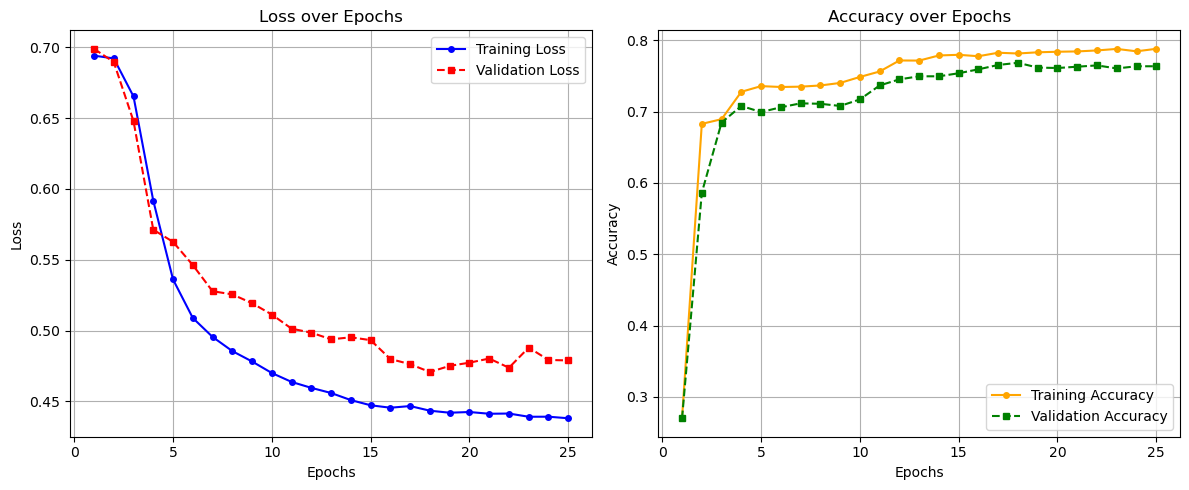

In [13]:
import matplotlib.pyplot as plt

# Function to plot loss and accuracy
def plot_loss_accuracy(loss_values, val_losses, accuracy_values, val_accuracy_values):
    epochs = range(1, len(loss_values) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Loss (Training and Validation)
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_values, label='Training Loss', color='blue', marker='o', markersize=4, linestyle='-')
    plt.plot(epochs, val_losses, label='Validation Loss', color='red', marker='s', markersize=4, linestyle='--')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()

    # Plot Accuracy (Training and Validation)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy_values, label='Training Accuracy', color='orange', marker='o', markersize=4, linestyle='-')
    plt.plot(epochs, val_accuracy_values, label='Validation Accuracy', color='green', marker='s', markersize=4, linestyle='--')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the plotting function after training
plot_loss_accuracy(loss_values, val_losses, accuracy_values, val_accuracy_values)


In [14]:
loss_values

[0.6941197127830692,
 0.6921802459693537,
 0.6653264345192328,
 0.5917352330393908,
 0.536129682238509,
 0.5089378065815786,
 0.4955589638977516,
 0.48554406369604713,
 0.4782008658095104,
 0.47006656374873185,
 0.4637701790507247,
 0.45956979830090594,
 0.45594910034319247,
 0.45093211255422455,
 0.4472837448847003,
 0.4455527003218488,
 0.4467250701857776,
 0.44344906537998013,
 0.4420189963608253,
 0.44253022292765176,
 0.4412945096812597,
 0.44144798386387707,
 0.43917809928335794,
 0.4392085733937054,
 0.4381208803595566]

In [15]:
val_losses

[0.6989554304343003,
 0.6896248494203274,
 0.6479024382737967,
 0.5712469821939101,
 0.5626586904892554,
 0.5462816088245466,
 0.5278106526686595,
 0.5255846186326101,
 0.5193316678588207,
 0.5113535901674857,
 0.5013554755311745,
 0.498538070000135,
 0.4938305209462459,
 0.49528791296940583,
 0.493254625166838,
 0.4799250421615747,
 0.47629090398550034,
 0.4707668853493837,
 0.47509863399542296,
 0.4773507502216559,
 0.4802683098958089,
 0.473798658985358,
 0.48801145587976164,
 0.4792785690380977,
 0.47892989963293076]

In [16]:
accuracy_values

[0.2702082057562768,
 0.6829454990814452,
 0.6895284751990202,
 0.7279546846295162,
 0.7359154929577465,
 0.7346907532149418,
 0.7351500306184936,
 0.73683404776485,
 0.7403551745254133,
 0.7487752602571953,
 0.7564298836497244,
 0.7718922229026332,
 0.7717391304347826,
 0.7789344764237599,
 0.7798530312308635,
 0.7778628291488059,
 0.7827617881200245,
 0.7816901408450704,
 0.7833741579914268,
 0.7841396203306797,
 0.7845988977342315,
 0.7859767299448868,
 0.7881200244947949,
 0.7847519902020821,
 0.7882731169626455]

In [17]:
val_accuracy_values

[0.26988984088127294,
 0.5862913096695227,
 0.6848225214198287,
 0.708078335373317,
 0.6995104039167687,
 0.7062423500611995,
 0.7117503059975521,
 0.7111383108935129,
 0.708078335373317,
 0.7172582619339045,
 0.7368421052631579,
 0.7454100367197063,
 0.7496940024479805,
 0.7496940024479805,
 0.7539779681762546,
 0.7594859241126071,
 0.7656058751529988,
 0.7686658506731946,
 0.7619339045287638,
 0.7613219094247246,
 0.7631578947368421,
 0.7649938800489596,
 0.7607099143206855,
 0.7637698898408812,
 0.7637698898408812]

In [18]:
import matplotlib.pyplot as plt

# Function to plot loss and accuracy on a single visualization
def plot_loss_accuracy(loss_values, val_losses, accuracy_values, val_accuracy_values):
    epochs = range(1, len(loss_values) + 1)
    plt.figure(figsize=(10, 6), dpi=300)  # Set the figure size and DPI for high quality

    # Plot Loss (Training and Validation)
    plt.plot(epochs, loss_values, label='Training Loss', color='blue', marker='o', markersize=4, linestyle='-')
    plt.plot(epochs, val_losses, label='Validation Loss', color='red', marker='s', markersize=4, linestyle='--')

    # Plot Accuracy (Training and Validation)
    plt.plot(epochs, accuracy_values, label='Training Accuracy', color='orange', marker='o', markersize=4, linestyle='-')
    plt.plot(epochs, val_accuracy_values, label='Validation Accuracy', color='green', marker='s', markersize=4, linestyle='--')

    # Add titles and labels
    plt.title('Loss and Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Value')
    plt.grid(True)
    plt.legend()

    # Save the figure as PNG and PDF with high quality
    plt.savefig("loss_accuracy_combined_plot.png", format="png", dpi=300)
    plt.savefig("loss_accuracy_combined_plot.pdf", format="pdf", dpi=300)

    # Show the plot
    plt.show()

# Step 5: Visualize Results

Files saved to:
/home/HardDisk/yared/training_plot.pdf
/home/HardDisk/yared/training_plot.png


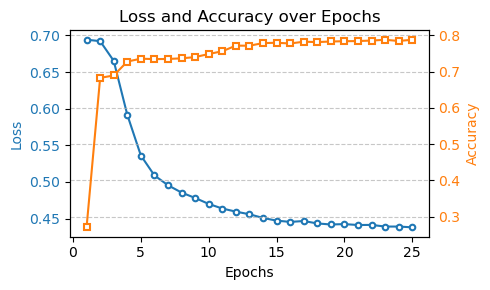

In [19]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

def plot_loss_accuracy(loss_values, accuracy_values):
    # Get current directory and create paths
    current_dir = os.getcwd()
    pdf_path = os.path.join(current_dir, 'training_plot.pdf')
    png_path = os.path.join(current_dir, 'training_plot.png')
    
    # Set up the plot with your original dimensions
    plt.figure(figsize=(5, 3))
    
    # Plot Loss (left y-axis) with enhanced styling
    plt.plot(range(1, len(loss_values) + 1), 
            loss_values, 
            label='Loss', 
            color='#1f77b4',
            marker='o',
            markerfacecolor='white',
            markeredgecolor='#1f77b4',
            markeredgewidth=1.5,
            markersize=4)
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss', color='#1f77b4')
    plt.tick_params(axis='y', labelcolor='#1f77b4')
    
    # Plot Accuracy (right y-axis) with enhanced styling
    ax2 = plt.gca().twinx()
    ax2.plot(range(1, len(accuracy_values) + 1), 
            accuracy_values, 
            label='Accuracy', 
            color='#ff7f0e',
            marker='s',
            markerfacecolor='white',
            markeredgecolor='#ff7f0e',
            markeredgewidth=1.5,
            markersize=4)
    
    ax2.set_ylabel('Accuracy', color='#ff7f0e')
    ax2.tick_params(axis='y', labelcolor='#ff7f0e')
    
    # Add titles and legends as in your original
    plt.title('Loss and Accuracy over Epochs')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Save high quality versions
    plt.savefig(pdf_path, format='pdf', dpi=300, bbox_inches='tight')
    plt.savefig(png_path, format='png', dpi=600, bbox_inches='tight')
    print(f"Files saved to:\n{pdf_path}\n{png_path}")
    
    plt.show()

# Your original function call remains the same
plot_loss_accuracy(loss_values, accuracy_values)

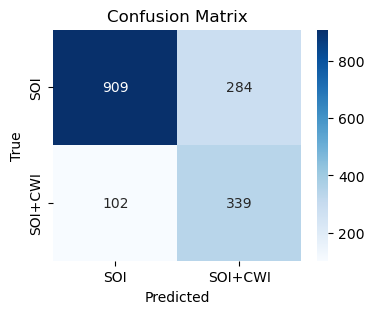


Classification Report:
              precision    recall  f1-score   support

         SOI       0.90      0.76      0.82      1193
     SOI+CWI       0.54      0.77      0.64       441

    accuracy                           0.76      1634
   macro avg       0.72      0.77      0.73      1634
weighted avg       0.80      0.76      0.77      1634



In [20]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['SOI', 'SOI+CWI'], yticklabels=['SOI', 'SOI+CWI'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['SOI', 'SOI+CWI']))

In [21]:
from sklearn.model_selection import train_test_split

# Assuming X and y are your features and labels for training data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)  # 20% for validation

# Prepare data loaders for training and validation
train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train))
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

val_data = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val))
validation_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)


In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Calculate metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred)

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")


Precision: 0.5441, Recall: 0.7687, F1 Score: 0.6372, ROC-AUC: 0.7653
